<div class="alert alert-block alert-warning">
<b>⚠⚠⚠ WARNING ⚠⚠⚠</b>   

This notebook can not run with lastest AeroMAPS developments including generic energy models.    
Please refer to v0.9.0-beta to run this notebook.
</div>

# Average efficiency gains callibration

### Imports and settings

In [1]:
import matplotlib.pyplot as plt
# import pandas as pd
# import numpy as np

%matplotlib widget
from aeromaps import create_process
from aeromaps.core.models import (
    default_models_bottom_up,
)


plt.rc("hatch", linewidth=1)

# 1 - Scenario initialisation and settings

In [2]:
from copy import deepcopy

models = {
    "default_models_bottom_up": default_models_bottom_up,
}

In [3]:
process = create_process(
    configuration_file="./data/config_calibration1.json",
    models=deepcopy(models),
)

## 1-b) Aircraft fleet

**Hypotheses considered for aircraft DOC and new aircraft introduction:**
The previously defined air traffic is flown by the default AeroMAPS fleet, and new aircraft. 

- A default fleet: an "old" and a "recent" aircraft for three markets: Short (<1500 km), Medium (1500-4000 km) and Long Range (>4000 km). 
- New aircraft are introduced
    - <u>Short Range:</u>
        - Drop-in aircraft in 2035
    - <u>Medium Range:</u>
        - Drop-in aircraft in 2035
    - <u>Long Range:</u>
        - Drop-in aircraft in 2040
        
    - Efficiency assumptions: drop in aircraft introduced in 2035 use 20% less energy than the current ("recent"), the long-range dropin aircraft introduced in 2040 uses 30% less energy than the "recent. 
    - Aircraft RC and NRC cost assumption are based on [this article](https://www.eucass.eu/doi/EUCASS2023-593.pdf), but these parameter are not used in this article. There is currently <u>no automated link between RC+NRC and DOC on AeroMAPS </u>. Consistent values are filed nevertheless. Same for ASK per year per A/C.
    
    
    - Aircraft DOC are obtained using the same article and regrouped in two categories
        - DOC-ENERGY is computed using the energy consumption of the aircraft and the MFSP of the corresponding energy (see below). 
        - DOC-NON-ENERGY encompass all other direct operating Costs (Navigation, FA/Pilots, MRO,...). The DOC-NE of drop-in aircraft is left unchanged.
        
    
    
- Aircraft fleet renewal rates are set to 25 years. It corresponds to both the aircraft life and the duration necessary to renew the whole fleet with current fleet renewal models of AeroMAPS.



Short Range (life=25y, limit=2, subcategories=1, share_sum=100.0%)
  - SR conventional narrow-body (share=100.0%, aircraft=1)
    - old reference (EIS=1970 y, energy/ASK=1.2472568306010927 MJ/ASK, DOC=0.048375 €/ASK, NOx=0.01514 kg/ASK, soot=3e-05 kg/ASK)
    - recent reference (EIS=2009.0045994444736 y, energy/ASK=0.9478251366120218 MJ/ASK, DOC=0.048375 €/ASK, NOx=0.01514 kg/ASK, soot=3e-05 kg/ASK)
    - New SR-DI (DROP_IN_FUEL, EIS=2035y, cons=-20%, NOx=0%, soot=0%, DOC=0%)
Medium Range (life=25y, limit=2, subcategories=1, share_sum=100.0%)
  - MR conventional narrow-body (share=100.0%, aircraft=1)
    - old reference (EIS=1970 y, energy/ASK=0.9163060109289617 MJ/ASK, DOC=0.0301 €/ASK, NOx=0.01514 kg/ASK, soot=3e-05 kg/ASK)
    - recent reference (EIS=2014.4654504665843 y, energy/ASK=0.6979234972677595 MJ/ASK, DOC=0.0301 €/ASK, NOx=0.01514 kg/ASK, soot=3e-05 kg/ASK)
    - New MR-DI (DROP_IN_FUEL, EIS=2035y, cons=-20%, NOx=0%, soot=0%, DOC=0%)
Long Range (life=25y, limit=2, subcategor

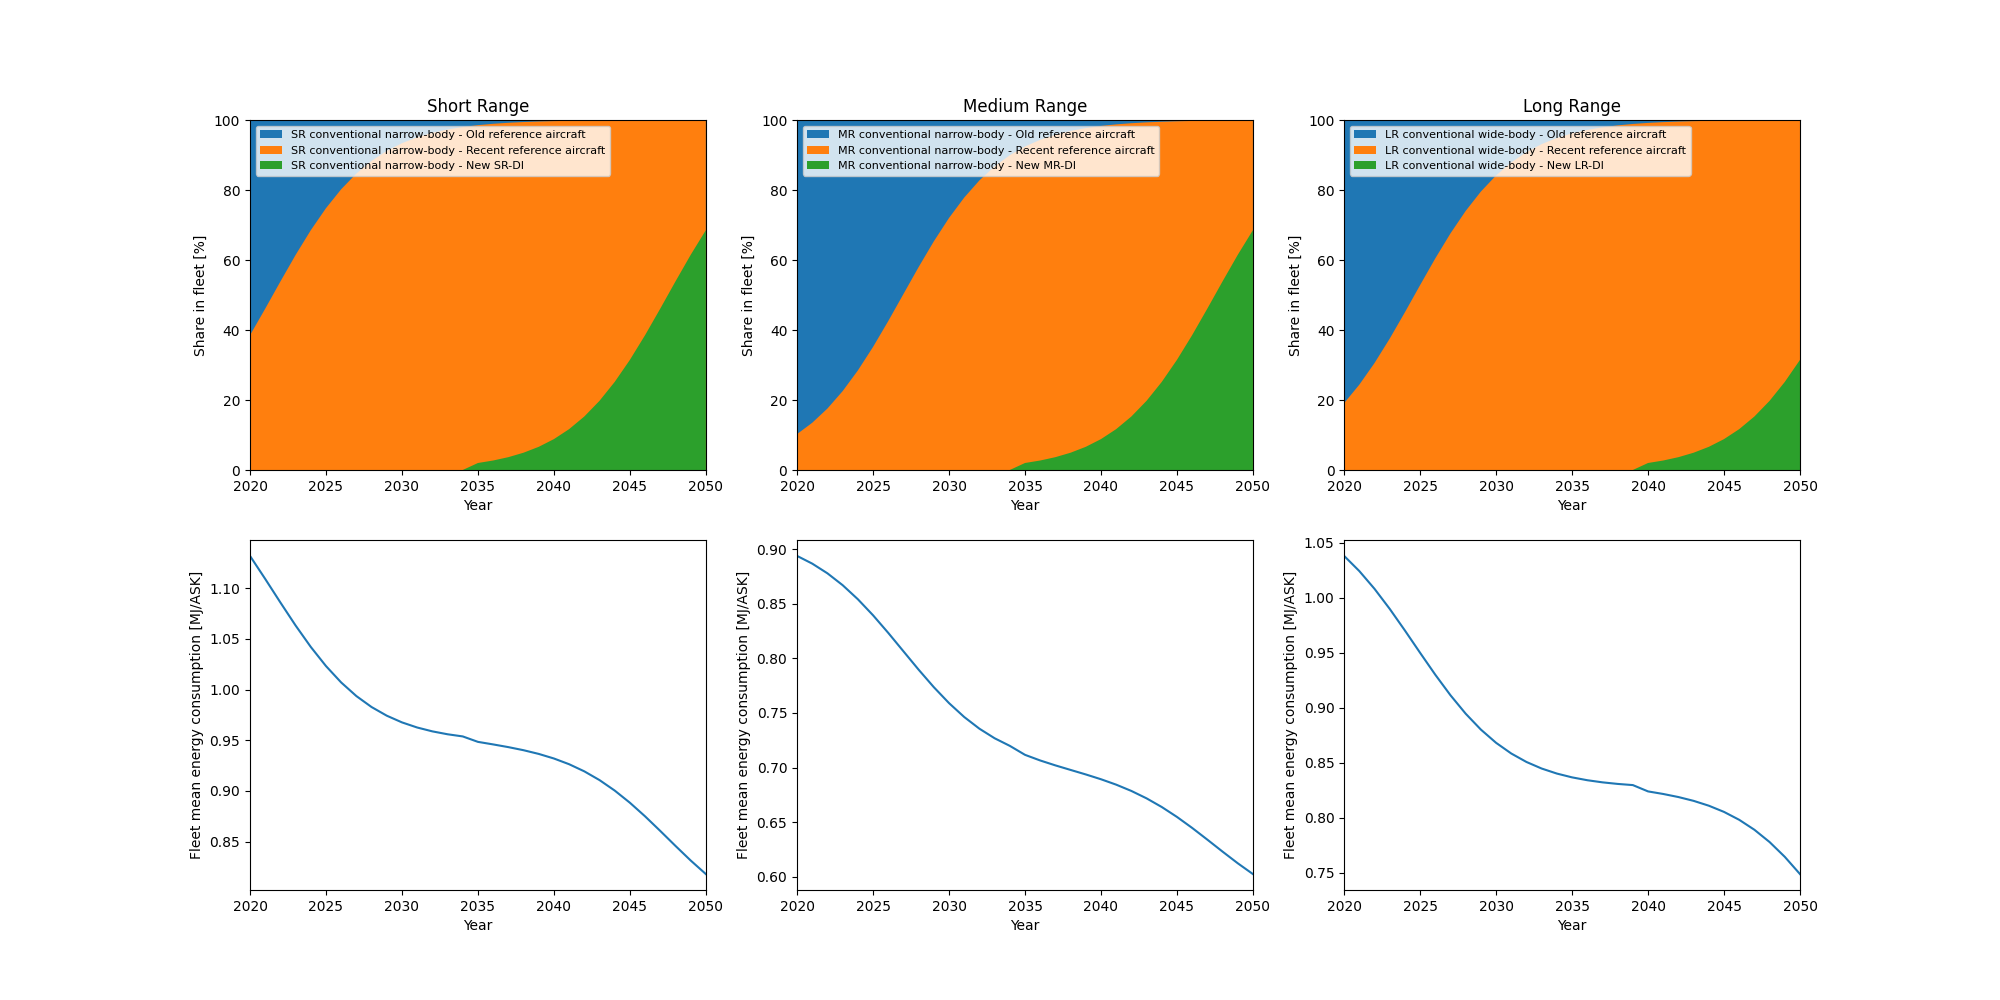

In [4]:
process.fleet.pretty_print()
process.fleet_model.compute()
process.fleet_model.plot()

In [5]:
process.compute()
process.write_json()

Running MDA


/Users/s.delbecq/VSCodeProjects/AeroMAPS/aeromaps/models/yaml_interpolator.py:91: UserWarning: 
[Interpolation Model: fossil_kerosene_mean_co2_emission_factor_without_resource Warning]
The first reference year (2000) differs from the prospection start year (2020).
Interpolation will begin at the first reference year.
  warnings.warn(
/Users/s.delbecq/VSCodeProjects/AeroMAPS/aeromaps/models/yaml_interpolator.py:91: UserWarning: 
[Interpolation Model: fossil_kerosene_mean_mfsp_without_resource Warning]
The first reference year (2000) differs from the prospection start year (2020).
Interpolation will begin at the first reference year.
  warnings.warn(


## 1-b) Computation of average efficiency gains

In [6]:
(
    process.data["vector_outputs"]["energy_per_ask_mean"][2050]
    / process.data["vector_outputs"]["energy_per_ask_mean"][2021]
) ** (1 / (2050 - 2021)) - 1

-0.013507706840146017

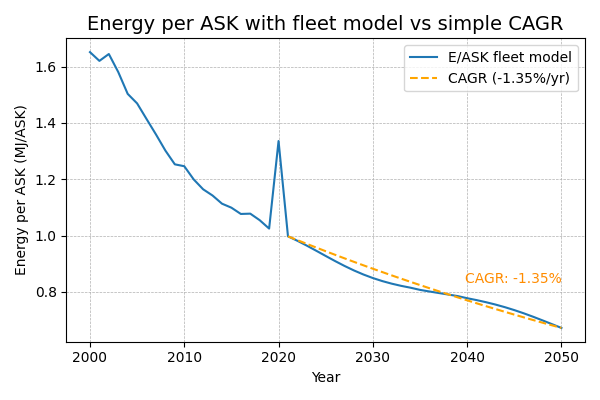

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Extract the data series
energy_per_ask = pd.Series(process.data["vector_outputs"]["energy_per_ask_mean"])

# Set time range and CAGR calculation
start_year = 2021
end_year = 2050
years = np.arange(start_year, end_year + 1)

# Actual values for those years (in case the series is longer or missing some)
actual = energy_per_ask.loc[years]

# Calculate CAGR
cagr = (actual[end_year] / actual[start_year]) ** (1 / (end_year - start_year)) - 1

# Generate the CAGR curve
cagr_curve = actual[start_year] * (1 + cagr) ** (years - start_year)

# Plot
plt.figure(figsize=(6, 4))
plt.plot(energy_per_ask.index, energy_per_ask.values, linestyle="-", label="E/ASK fleet model")
plt.plot(years, cagr_curve, linestyle="--", color="orange", label=f"CAGR ({cagr*100:.2f}%/yr)")

# Annotate CAGR
plt.text(
    end_year,
    cagr_curve[-1] + 0.15,
    f"CAGR: {cagr*100:.2f}%",
    verticalalignment="bottom",
    horizontalalignment="right",
    fontsize=10,
    color="darkorange",
)

# Formatting
plt.title("Energy per ASK with fleet model vs simple CAGR", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Energy per ASK (MJ/ASK)")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

## 1-c) Computation of a pessimistic scenario in which no new aircraft is introduced

In [8]:
process_pess = create_process(
    configuration_file="./data/config_calibration2.json",
    models=models,
)

process_pess.compute()

Running MDA


/Users/s.delbecq/VSCodeProjects/AeroMAPS/aeromaps/models/yaml_interpolator.py:91: UserWarning: 
[Interpolation Model: fossil_kerosene_mean_co2_emission_factor_without_resource Warning]
The first reference year (2000) differs from the prospection start year (2020).
Interpolation will begin at the first reference year.
  warnings.warn(
/Users/s.delbecq/VSCodeProjects/AeroMAPS/aeromaps/models/yaml_interpolator.py:91: UserWarning: 
[Interpolation Model: fossil_kerosene_mean_mfsp_without_resource Warning]
The first reference year (2000) differs from the prospection start year (2020).
Interpolation will begin at the first reference year.
  warnings.warn(


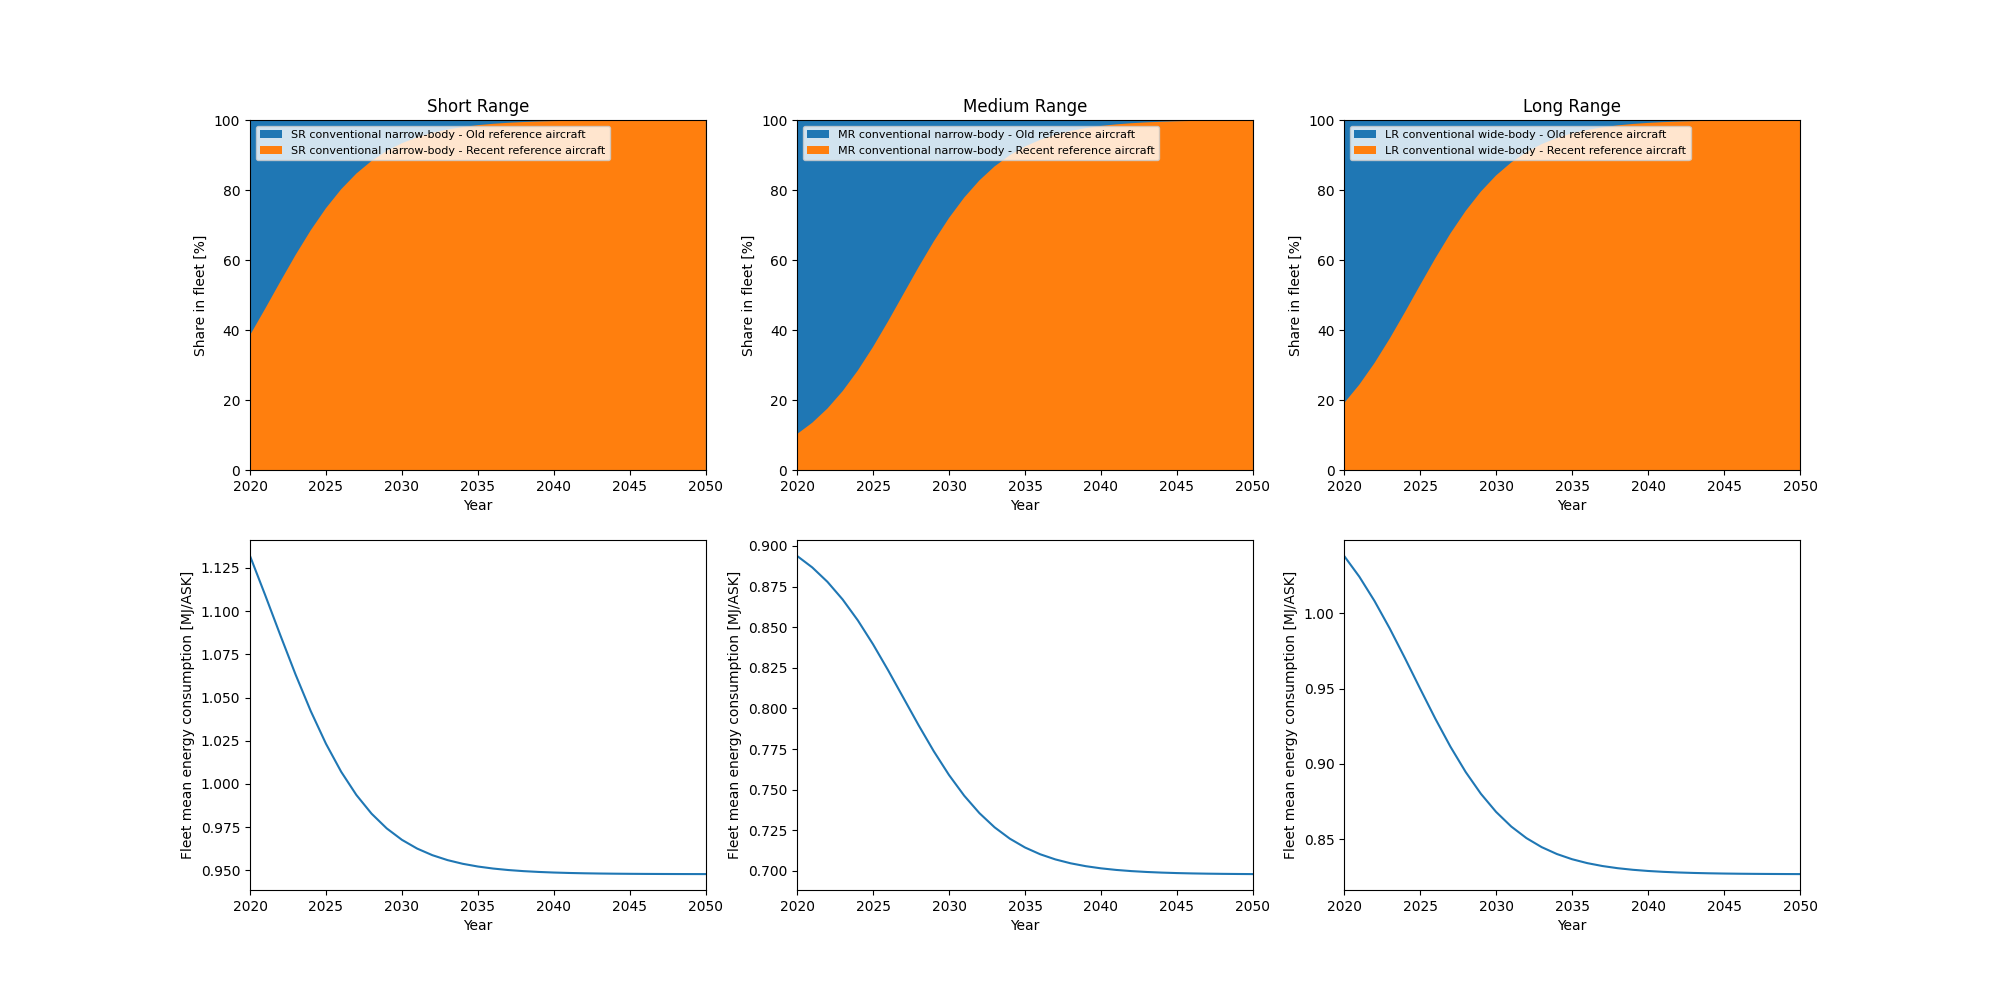

In [9]:
process_pess.fleet_model.plot()

In [10]:
(
    process_pess.data["vector_outputs"]["energy_per_ask_mean"][2050]
    / process_pess.data["vector_outputs"]["energy_per_ask_mean"][2021]
) ** (1 / (2050 - 2021)) - 1

-0.009121558296727561